# Discharge estimation: salt injection method
Simple code to understand how to estimate discharge using the salt injection method

*Marc Girons Lopez*  
*2016-09-21*

In [215]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Overview
The idea is to estimate the discharge by using a tracer (i.e. salt solution). The tracer is injected in the stream and the conductivity (i.e. a proxy for concentration) is measured through time. The resulting discharge (Q) is thereafter calculated by:

## $Q = \frac{V_{salt}}{\beta(\gamma-\gamma_{bg})dt}$

In order to determine the relationship between concentration and conductivity a simple calibration needs to be done.

## Calibration

Get a known volume of streamwater in two buckets. The first bucket will be used to create the salt solution (tracer) while the second will be used to perform the calibration.

In [216]:
vol_ss = 15  # Volume salt solution, litres
vol_cal = 10  # Volume calibration, litres

Afterwards we measure the **background conductivity** in one of the buckets:

In [217]:
cond_bg = 25.5  # Background conductivity, micro Siemens per cm

Then we proceed to the actual calibration. First we add a certain amount of salt in one of the buckets and stir to dissolve it. We have our salt solution (tracer). Thereafter we add small amounts of the tracer to the bucket with streamwater and measure the conductivity increases.

The first point corresponds to the streamwater before adding any volume of salt solution. The following points are obtained by adding a small volume of salt solution to the known volume of straemwater and subsequently measuring the conductivity. Four points is usually enough.

In [218]:
vol_ss_cal = 0.5  # Salt solution volume to add, ml
steps = 3  # number of steps in the calibration

# start the arrays
conc = np.zeros(steps)  # Salt solution concentration, ml/l
cond = np.zeros(steps)  # Conductivity

# actual conductivity measurements
measurements = [cond_bg, 32.2, 38.8]

# perform the calibration
for step in range(steps):
    cond[step] = measurements[step]
    if step == 0:
        conc[step] = 0.00
    else:
        # calibration
        conc[step] = conc[step-1] + (vol_ss_cal / vol_cal)
        # update de volumes
        vol_ss -= vol_ss_cal
        vol_cal += vol_ss_cal

# calculate the conductivity difference
cond_diff = cond - cond_bg

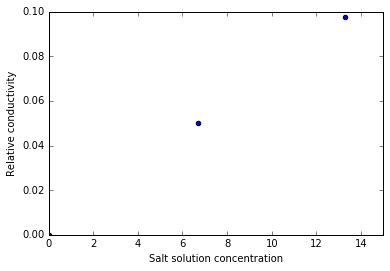

In [219]:
# plot the calibration steps
plt.scatter(cond_diff, conc)
plt.xlim(0, 15)
plt.ylim(0, 0.10)
plt.xlabel('Salt solution concentration')
plt.ylabel(r'Relative conductivity')

Perform a linear regression to find the relationship between concentration and conductivity

In [220]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cond_diff, conc) 

print('y = ' + str(slope) + 'x + ' + str(intercept))
print('R2 = ' + str(r_value**2))

y = 0.0073400883682x + 0.000272426751661
R2 = 0.999905138691


## Measurement

Inject the known volume of salt solution to the stream and measure the conductivity through time:

In [221]:
time = pd.Series([0, 5, 10, 15, 20, 25, 30, 35, 40,
                   45, 50, 55, 60, 65, 70, 75, 80,
                   85, 90, 95, 100, 105, 110, 115,
                   120, 125, 130, 135, 140, 145, 150,
                   155, 160, 190, 220, 250, 280, 420],
                  name='Time (s)')

cond = pd.Series([25.5, 27, 30, 32, 34.5, 37,
                  38, 39, 38, 37.5, 36, 35,
                  34, 33, 32.5, 32, 31.7, 31.5,
                  30.5, 30, 29.5, 29, 28.7,
                  28.5, 28.2, 28, 27.8, 27.7,
                  27.6, 27.5, 27.2, 27.1, 27,
                  26.5, 26.2, 26, 26, 25.5],
                  index=time, name='Conductivity')

Calculate the relative conductivity respect to the background value

In [222]:
cond_diff = cond - cond_bg

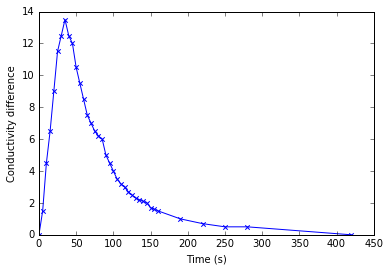

In [223]:
# plot the conductivity difference against time
plt.plot(time, cond_diff)
plt.scatter(time, cond_diff, marker='x')
plt.xlim(0, 450)
plt.ylim(0, 14)
plt.xlabel('Time (s)')
plt.ylabel('Conductivity difference')

## Calculation

The first step is to calculate the area under the curve:

In [224]:
area = np.trapz(cond_diff, x=time)

Then we need use the results from the calibration to convert from conductivity units to concentration units.

In [225]:
area2 = area * slope + intercept

Finally, we divide the injected salt solution (in ml) by the result of the conversion:

In [228]:
Q = (vol_ss * 1000) / area2

print('Q = ' + str(Q) + ' l/s')

Q = 1795.49761882 l/s
